In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import img_with_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [4]:
experiments_paths = {
    "misgan": Path("../results/mnist/misgan/"),
    # "gmm_only_hidden": Path("../results/mnist/misgan_like/14x14/"),
    # "gmm_missing_and_hidden": Path("../results/mnist/misgan_like/14x14_two_holes/"),
    "torch_mfa": Path("../../gmm_missing/models/mnist"),
    "gmm_fullconv": Path("../results/mnist/long_trainings/fullconv_v1"),
    "gmm_linear_heads": Path("../results/mnist/long_trainings/linear_v1"),
}

In [5]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [6]:
x, j, p, m ,a, d, y = experiments_results["torch_mfa"][0]

In [7]:
# [t.shape for t in [x, j, p, m, a, d, y]]

In [8]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), r[-1]) for r in results]

# NLL and MSE

In [9]:
ml_metrics = {
    name: [
        (ev.loss_like_metrics(res), res)
        for res in results
    ]
    for name, results in tqdm(experiments_results.items())
}

100%|██████████| 4/4 [01:13<00:00, 18.41s/it]


In [10]:
ml_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        **m[0]
    }
    for model, metrics in ml_metrics.items()
    for m in metrics
])

ml_metrics_df

,imputer_model,nll,mse
0,misgan,0.000000,14.488270
1,misgan,0.000000,21.611164
2,misgan,0.000000,5.466640
3,misgan,0.000000,27.613018
4,misgan,0.000000,14.821939
...,...,...,...
39995,gmm_linear_heads,-145.105545,14.012247
39996,gmm_linear_heads,-151.375305,25.087900
39997,gmm_linear_heads,-475.694794,7.355198
39998,gmm_linear_heads,-579.062744,4.654380


In [11]:
ml_metrics_df.groupby("imputer_model").agg(["mean", "std"])

nll                    mse           
                        mean         std       mean        std
imputer_model                                                 
gmm_fullconv     -165.363661  318.317436  14.531253   6.858685
gmm_linear_heads -244.811695  363.773790  12.967024   6.507890
misgan              0.000000    0.000000  27.257229  14.438440
torch_mfa          67.619344  410.735482  18.723711  15.279746

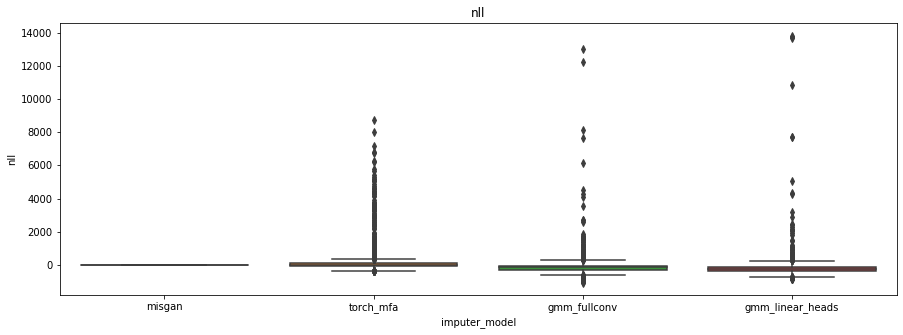

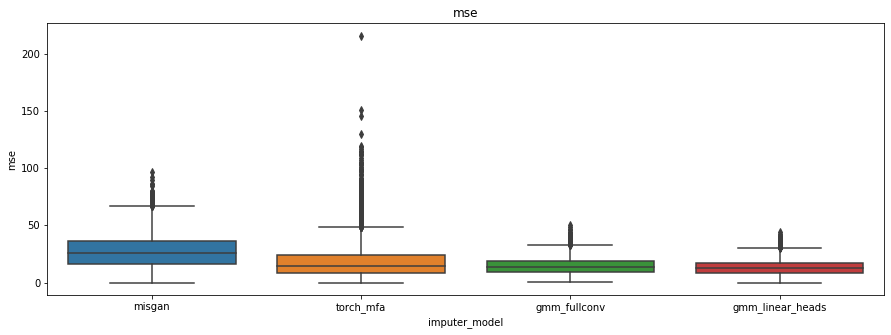

In [12]:
for metric in ["nll", "mse"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=ml_metrics_df,
        y=metric,
        # x="img_kind",
        x="imputer_model"
    )
    plt.show()

# Worst and best NLL cases for every model

misgan worst 5


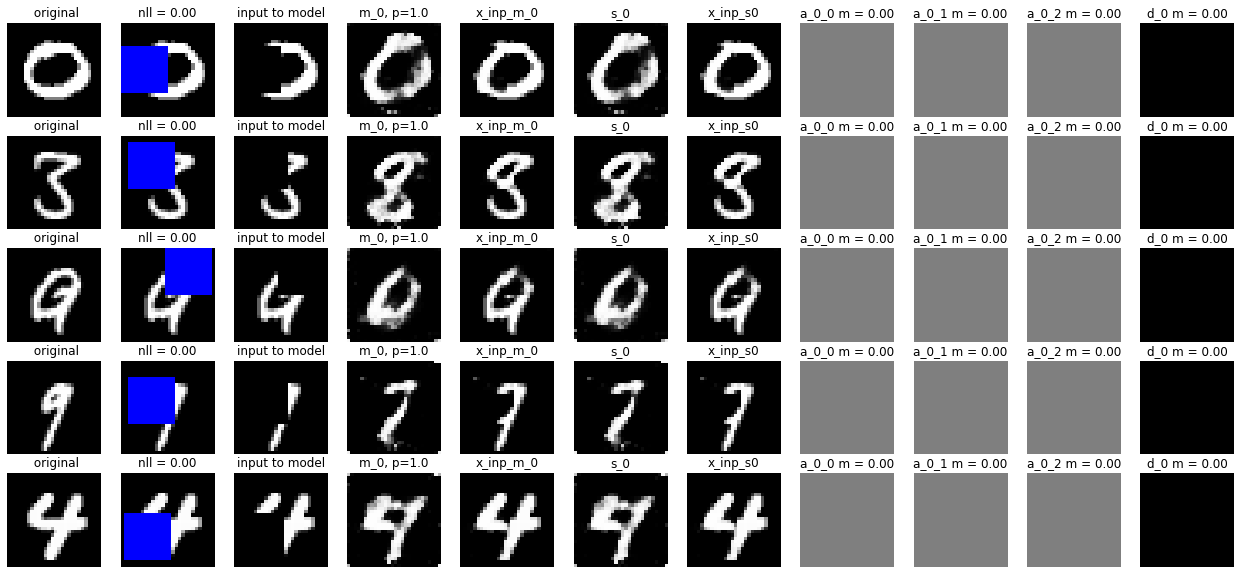

misgan best 5


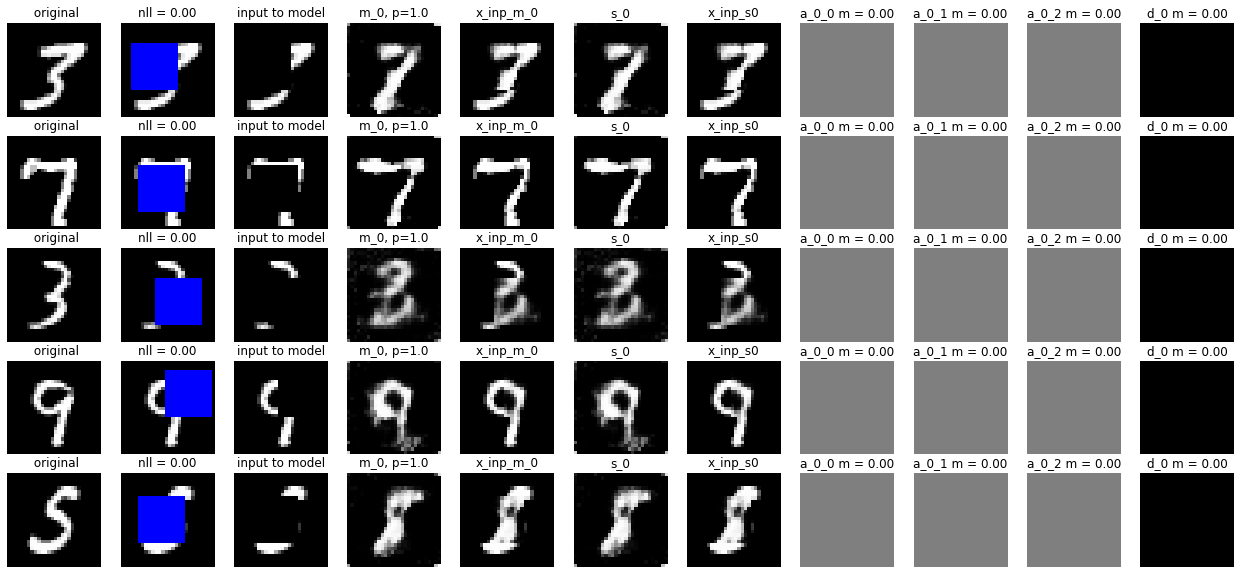

torch_mfa worst 5


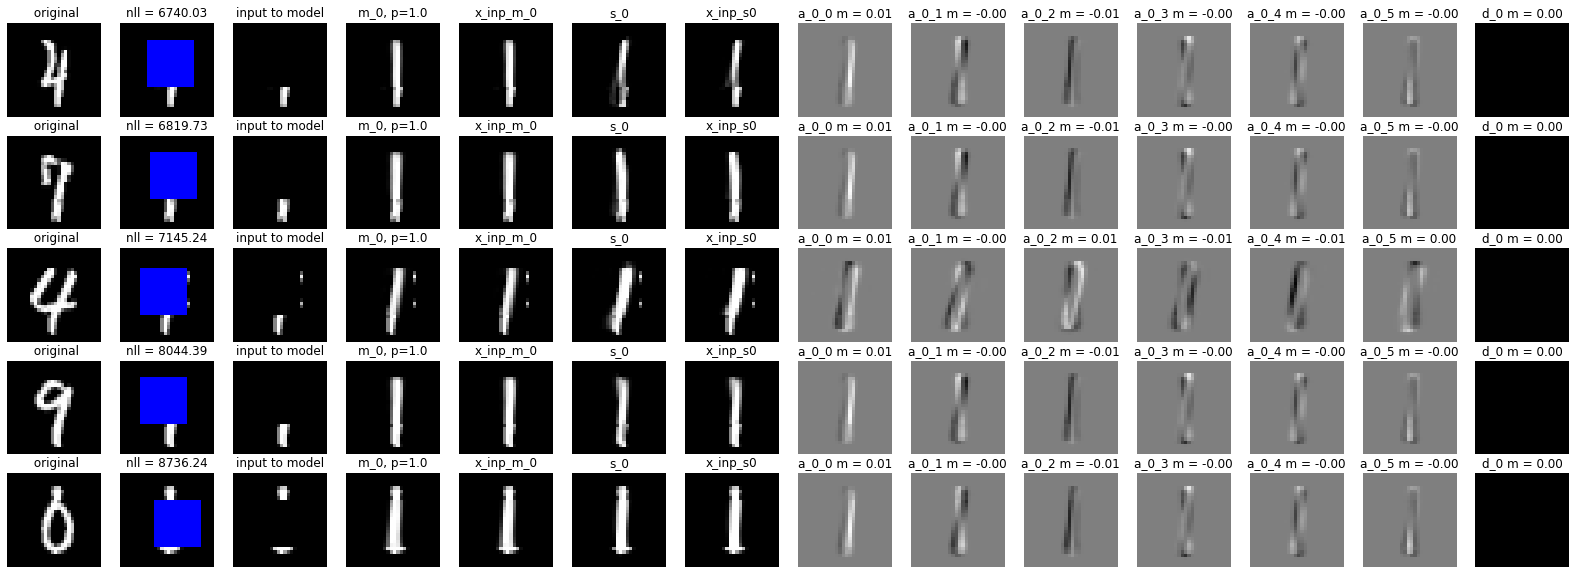

torch_mfa best 5


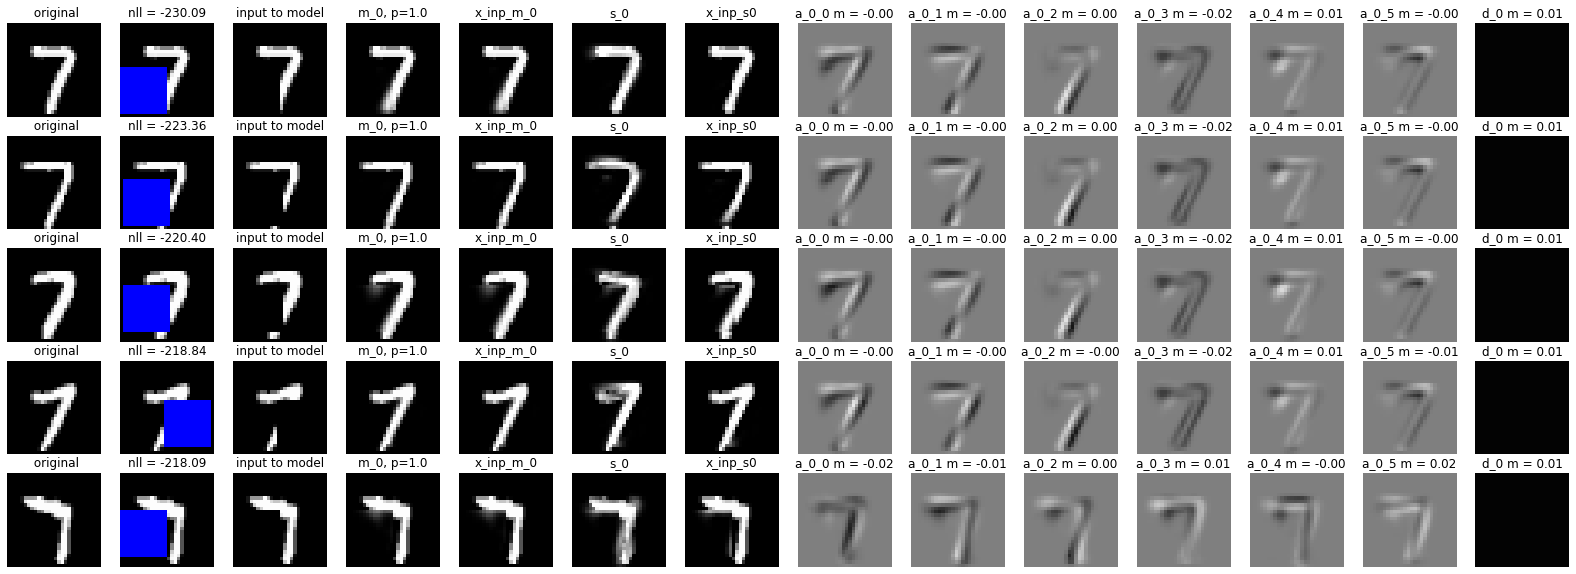

gmm_fullconv worst 5


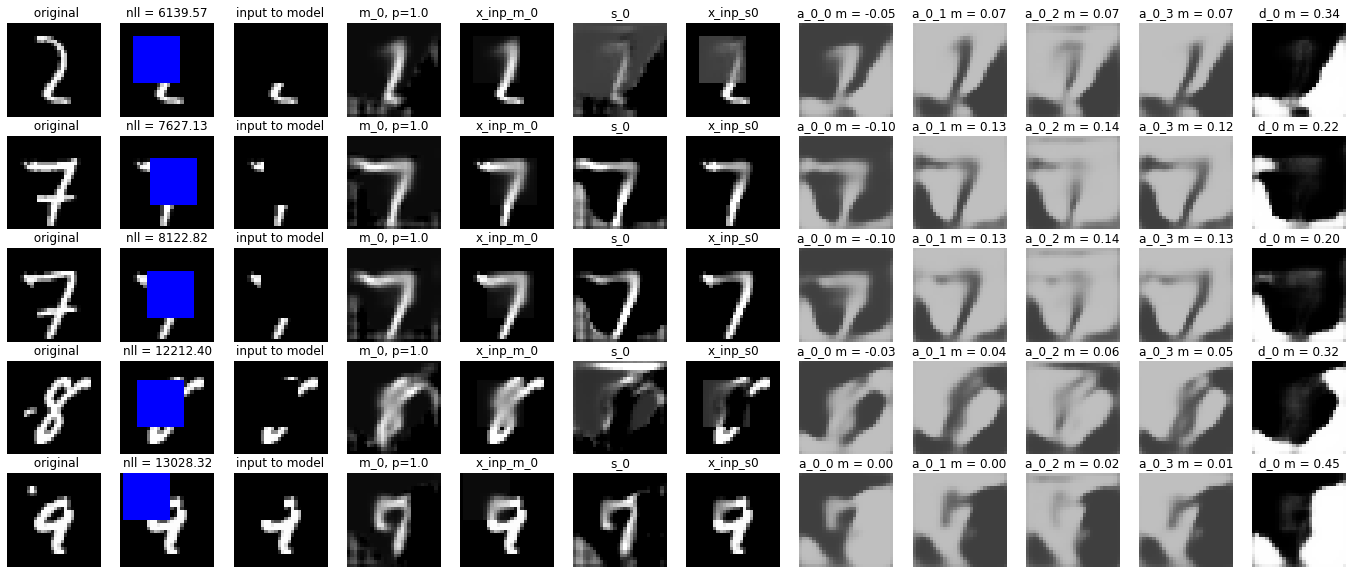

gmm_fullconv best 5


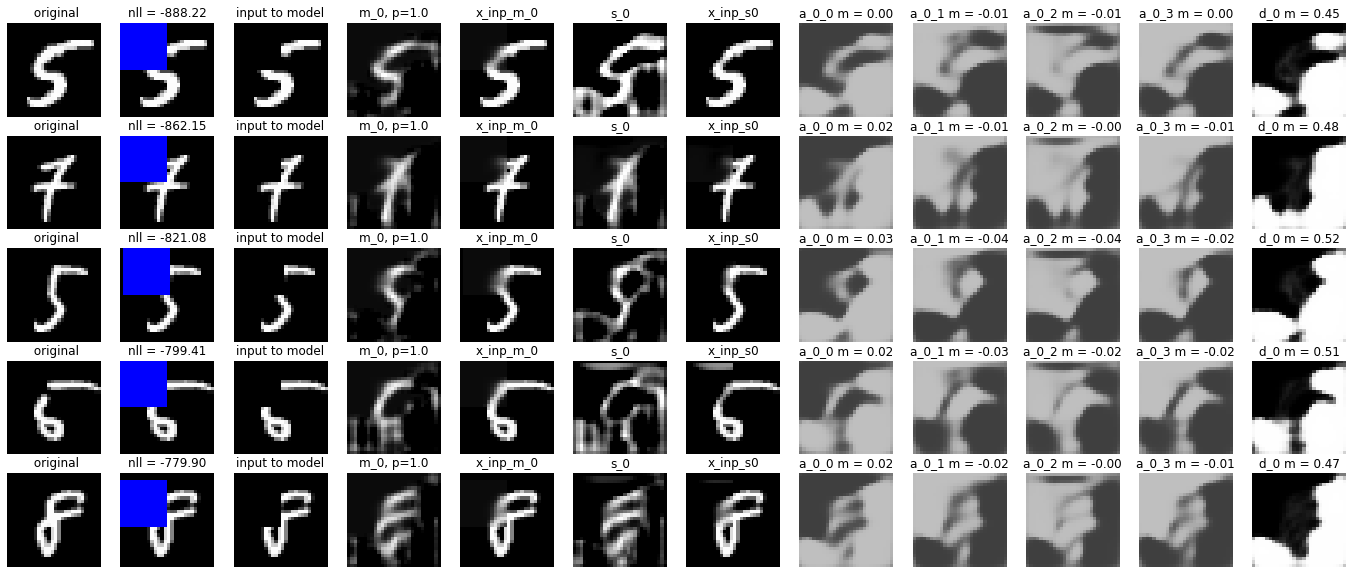

gmm_linear_heads worst 5


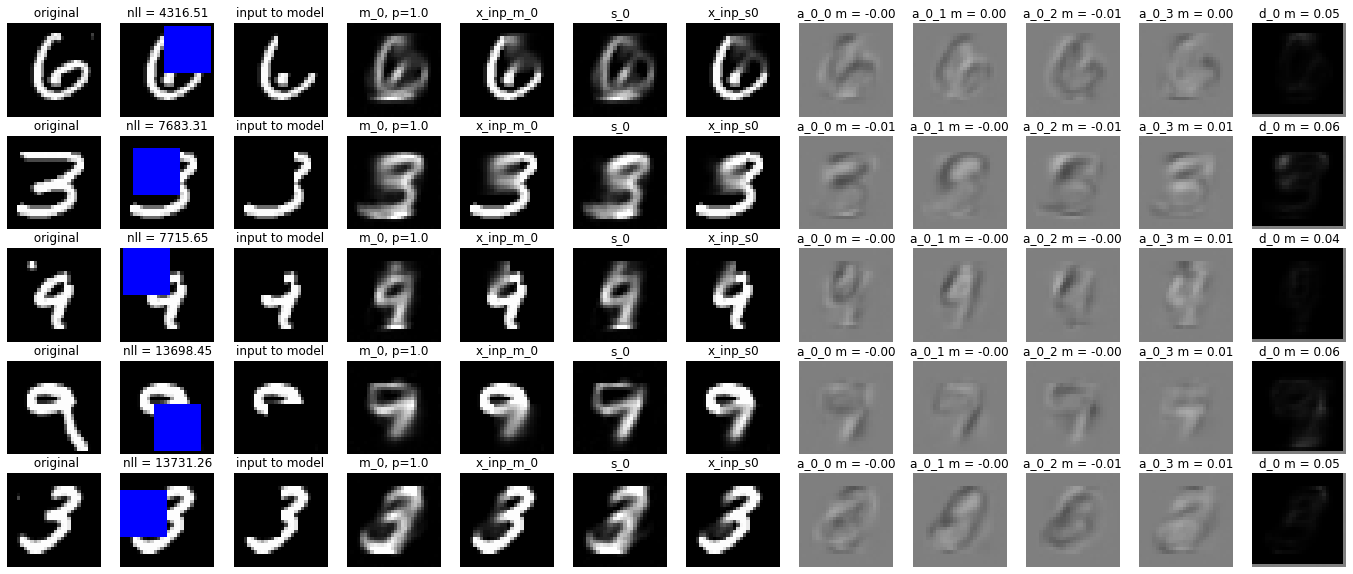

gmm_linear_heads best 5


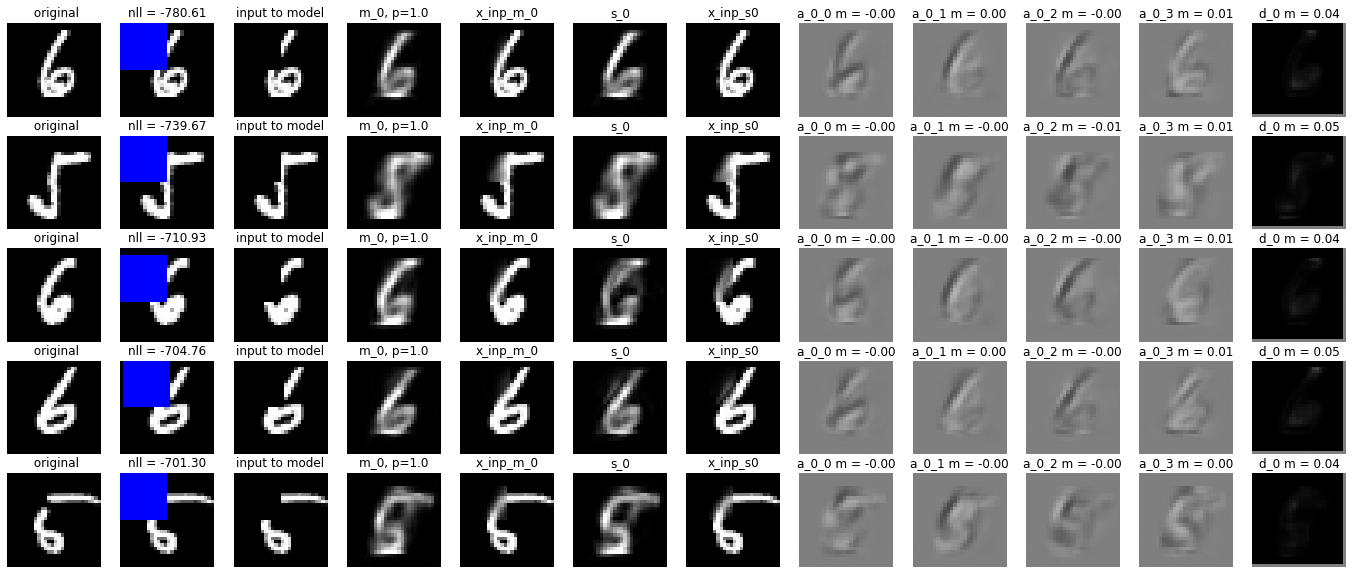

In [13]:
n = 5
for model, metrics_with_cases in ml_metrics.items():
    metrics_with_cases = sorted(
        metrics_with_cases, key = lambda m_c: m_c[0]["nll"]
    )
    metrics_with_cases = [
        m for m in metrics_with_cases if m[1][-1] != 1
    ] 
    for (name, mwc) in [
        ("worst", metrics_with_cases[-n:]),
        ("best", metrics_with_cases[:n])
    ]:
        print(model, name, n)
        row_len = vis.row_length(
            *metrics_with_cases[0][1]
        )
        fig, ax = plt.subplots(nrows=n, ncols=row_len, figsize=(2* row_len, n * 2))
        for i, (m, c) in enumerate(mwc):
            vis.visualize_sample(
                *c,
                ax_row=ax[i]
            )
            ax[i, 1].set_title(
                f"nll = {m['nll']:.2f}"
            )
        plt.show()



# Skimage metrics

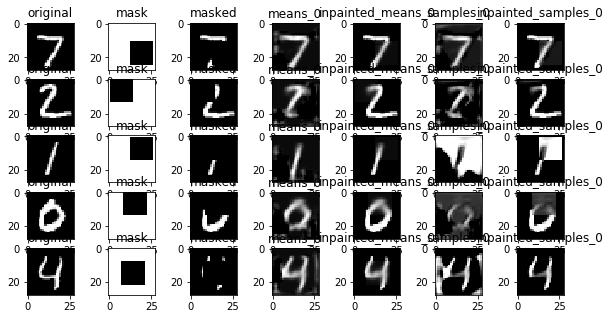

In [14]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v.squeeze(), cmap="gray", vmin=0, vmax=1)
            ax[i][j].set_title(k)

plot_exp_images(experiments_images["gmm_fullconv"][:5], figsize=(10, 5))

In [15]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in img_dicts
    ]
    for name, img_dicts in experiments_images.items()
}

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)


In [16]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"] #if metric["img_kind"] #in ["inpainted_means_0", "inpainted_samples_0"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,misgan,3,original,1.000000,inf
1,misgan,3,mask,-0.018351,1.499226
2,misgan,3,masked,0.640563,12.955039
3,misgan,3,means_0,0.575092,11.611971
4,misgan,3,inpainted_means_0,0.845908,17.332995
...,...,...,...,...,...
279995,gmm_linear_heads,6,masked,0.628482,11.051377
279996,gmm_linear_heads,6,means_0,0.587709,12.746711
279997,gmm_linear_heads,6,inpainted_means_0,0.862934,17.307263
279998,gmm_linear_heads,6,samples_0,0.552621,12.481106


In [17]:
per_image_metrics_df.drop("label", axis=1).groupby(
    ["imputer_model", "img_kind"]
).agg(
    lambda pts: "{0:.2f} ± {1:.2f}".format(np.mean(pts), np.std(pts) )
     ).reset_index().to_csv("ssim_psnr.csv")

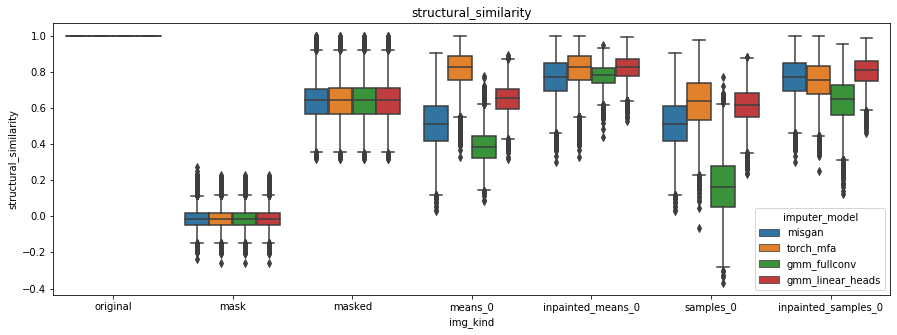

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/sit

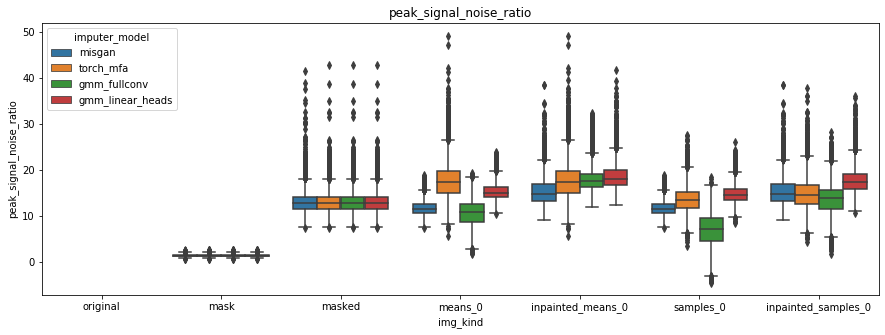

In [18]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Frechet distance

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 1024, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

cuda


  0%|          | 0/59 [00:00<?, ?it/s]

0 0.96875


  2%|▏         | 1/59 [00:00<00:05,  9.99it/s]

1 0.98046875


  2%|▏         | 1/59 [00:00<00:09,  6.11it/s]

2 0.9818359375


  2%|▏         | 1/59 [00:00<00:05,  9.91it/s]

3 0.9849609375


100%|██████████| 59/59 [00:06<00:00,  9.36it/s]


4 0.984765625


In [20]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [21]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [22]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [23]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

,imputer_model,kind,frechet_distance
0,misgan,original,-1.421085e-14
1,misgan,mask,3.059501e+01
2,misgan,masked,1.116607e+01
3,misgan,means_0,3.363018e+00
4,misgan,inpainted_means_0,1.160297e+00
5,misgan,samples_0,3.363018e+00
6,misgan,inpainted_samples_0,1.160297e+00
7,torch_mfa,original,0.000000e+00
8,torch_mfa,mask,3.066396e+01
9,torch_mfa,masked,1.109584e+01


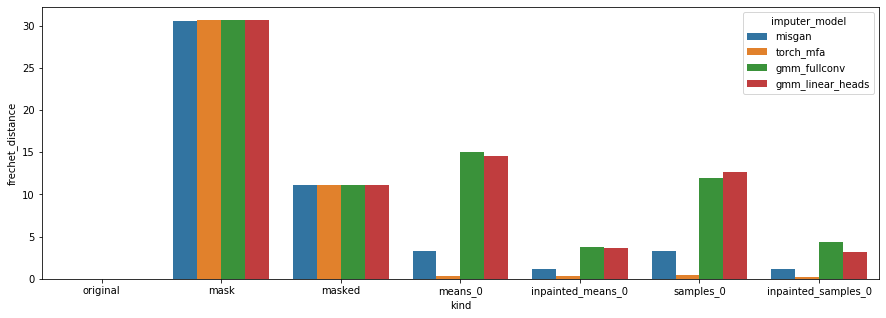

In [24]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)

In [25]:
frechet_dists_df.to_csv("frechet_dists_tmp.csv")